# Workshop 3: Datenbanken erstellen (DML und DDL)

* Schwierigkeit: einfach
* Prüfungsrelevant: nein
* Zeitaufwand: 45min

Mit der Data Modelling Language (DML) und der Data Definition Language (DDL) werden Datenbanken spezifiziert. Datenbankmodellierung ist ein Spezialgebiet und kann hier nur sehr oberflächlich behandelt werden. Mit einigen grundlegenden Kenntnissen können aber problemlos Datenbanken für den Alltagseinsatz erstellt werden.


In [1]:
# Hilfsfunktionen laden und ...
from util.sqlite_util import *
from shutil import copyfile

# wir erstellen eine Kopie der chinook-datenbank
copyfile("./data/chinook.sqlite", "./data/chinook_copy.sqlite")

# ... Test-Datenbank öffnen
path = get_connection_path("chinook_copy.sqlite")
connection = create_connection(path)

Connection to SQLite DB 2.6.0 (./data/chinook_copy.sqlite) successful


## 1. Data Manipulation Language (DML)

Mit DML können Daten in ein existierendes Schema eingefügt, angepasst und gelöscht werden. Die Hauptbefehle sind
* INSERT 
* UPDATE
* DELETE
* (REPLACE) - wird hier nicht behandelt

### INSERT

``` sql
INSERT INTO table (column1,column2 ,..)
VALUES( value1, value2 ,...);
``` 

Beispiel 1.1:  INSERT in die Tabelle `artist`

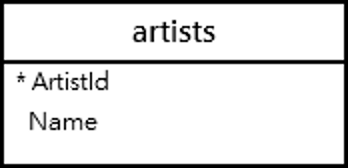

ArtistId wird automatisch gesetzt (AUTO INCREMENT)


In [ ]:
stmt = """
INSERT INTO artists (name) 
VALUES('Bud Powell');
"""
cur = execute_query(connection, stmt)
# INSERT hat keinen Rückgabewert

In [ ]:
# small helper class
def __print_artists():
    stmt = """
    SELECT
        ArtistId,
        Name
    FROM
        Artists
    ORDER BY
        ArtistId DESC
    LIMIT 3;
    """
    cur = execute_query(connection, stmt)
    print_results(cur)

__print_artists()

['ArtistId', 'Name']
(292, 'Bud Powell')
(275, 'Philip Glass Ensemble')
(274, 'Nash Ensemble')


In [ ]:
# Beispiel 1.2; es geht auch mit mehreren Datensätzen
stmt = """
INSERT INTO artists (name) 
VALUES 
  ("Buddy Rich"), 
  ("Candido"), 
  ("Charlie Byrd");
"""

### UPDATE

Mit UPDATE können bestehende Datensätze aktualisiert werden. 

In [ ]:
stmt = """
UPDATE artists
SET name = 'Baden Powell'
WHERE name = 'Bud Powell' 
LIMIT 1;
"""
cur = execute_query(connection, stmt)

__print_artists()

['ArtistId', 'Name']
(292, 'Baden Powell')
(275, 'Philip Glass Ensemble')
(274, 'Nash Ensemble')


### DELETE

In [ ]:
stmt = """
DELETE FROM artists
WHERE name LIKE "%Powell%";
"""
cur = execute_query(connection, stmt)

__print_artists()

['ArtistId', 'Name']
(275, 'Philip Glass Ensemble')
(274, 'Nash Ensemble')
(273, 'C. Monteverdi, Nigel Rogers - Chiaroscuro; London Baroque; London Cornett & Sackbu')


### Tabelle kopieren

In [ ]:
# Zuerst verwenden wir DDL, um eine neue, leeere Tabelle zu kreieren
stmt = """
CREATE TABLE artists_backup(
   ArtistId INTEGER PRIMARY KEY AUTOINCREMENT,
   Name NVARCHAR
);
"""
execute_query(connection, stmt)

# falls die Tabelle bereits exisitert, gibt es hier eine Fehlermeldung. 
# Um dies zu unterdrücken, kann CREATE TABLE IF NOT EXISTS verwendet werden. Mache ich hier bewusst nicht.

# nun wird die Tabelle 'artists' kopiert
stmt = """
INSERT INTO artists_backup 
SELECT ArtistId, Name
FROM artists;
"""
execute_query(connection, stmt)

# zeige anzahl reihen in artists_Backup
cur = execute_query(connection, "SELECT count(*) FROM artists_backup;")
print(cur.fetchone())

# und lösche artists_backup wieder
cur = execute_query(connection, "DROP TABLE artists_backup;")

(274,)


## Data Definition Language
DDL wird verwendet, um Datenschematas zu erzeugen, ändern und löschen. Die wichtigsten Befehle sind:
* CREATE TABLE
* UPDATE TABLE
* DROP TABLE

In [ ]:
# Wir wechseln zur Test-Datenbank
connection.close()
# ... Test-Datenbank öffnen
path = get_connection_path("sql_kurs.sqlite")
connection = create_connection(path)

Connection to SQLite DB 2.6.0 (./data/sql_kurs.sqlite) successful


Folgende Beispieldatenbank wird hier erzeugt
![Beispielsdatenbank](./img/SQLite-Foreign-Key-Example.png)

In [ ]:
stmt="""
CREATE TABLE supplier_groups (
	group_id integer PRIMARY KEY,
	group_name text NOT NULL
);
"""
execute_query(connection, stmt)

stmt ="""
CREATE TABLE suppliers (
    supplier_id   INTEGER PRIMARY KEY,
    supplier_name TEXT    NOT NULL,
    group_id      INTEGER NOT NULL,
    FOREIGN KEY (group_id)
       REFERENCES supplier_groups (group_id) 
);
"""
execute_query(connection, stmt)


print(show_tables(connection))
print("\nDetails zur Tabelle 'suppliers':")
print(desc_table(connection, "suppliers"))



['supplier_groups', 'suppliers']

Details zur Tabelle 'suppliers':
CREATE TABLE suppliers (
    supplier_id   INTEGER PRIMARY KEY,
    supplier_name TEXT    NOT NULL,
    group_id      INTEGER NOT NULL,
    FOREIGN KEY (group_id)
       REFERENCES supplier_groups (group_id) 
)


In [ ]:
# und wir löschen die Tabellen wieder
execute_query(connection, "drop table if exists supplier_groups")
execute_query(connection, "drop table if exists suppliers")
print(show_tables(connection))

[]


## Aufgabe 13: DDL und DML

Gegeben ist folgendes Datenbankschema.

![Datenbank-Schema](./img/SQLite-CREATE-TABLE-example.jpg)

* a) Benutze CREATE TABLE, um das Schema zu erzeugen.
* b) Fülle die Tabelle mit einigen Beispieldaten mit INSERT INTO
* c) Lösche die Tabellen mit DROP TABLE
* d) Zeige alle Contacts mit den zugewiesenen Gruppe in einer Tabelle.

In [ ]:
# c) Lösche die Tabellen mit DROP TABLE
execute_query(connection, "DROP TABLE IF EXISTS groups")
execute_query(connection, "DROP TABLE IF EXISTS contacts")
execute_query(connection, "DROP TABLE IF EXISTS contact_groups")
print(show_tables(connection))

[]


In [ ]:
# a) Benutze CREATE TABLE, um das Schema zu erzeugen.
stmt = """
CREATE TABLE IF NOT EXISTS contacts (
	contact_id INTEGER PRIMARY KEY,
	first_name TEXT NOT NULL,
	last_name TEXT NOT NULL,
	email TEXT NOT NULL UNIQUE,
	phone TEXT NOT NULL UNIQUE
);"""
execute_query(connection, stmt)


stmt = """
CREATE TABLE IF NOT EXISTS groups (
   group_id INTEGER PRIMARY KEY,
   name TEXT NOT NULL
);"""
execute_query(connection, stmt)


stmt ="""
CREATE TABLE IF NOT EXISTS contact_groups(
   contact_id INTEGER,
   group_id INTEGER,
   PRIMARY KEY (contact_id, group_id),
   FOREIGN KEY (contact_id) 
      REFERENCES contacts (contact_id) 
         ON DELETE CASCADE 
         ON UPDATE NO ACTION,
   FOREIGN KEY (group_id) 
      REFERENCES groups (group_id) 
         ON DELETE CASCADE 
         ON UPDATE NO ACTION
);"""
execute_query(connection, stmt)
print(show_tables(connection))


['contacts', 'groups', 'contact_groups']


In [ ]:
# b) Fülle die Tabelle mit einigen Beispieldaten mit INSERT INTO
stmt = """
INSERT INTO groups (name)
VALUES ("privat"), ("business"), ("familie"), ("freizeit");"""
execute_query(connection, stmt)
cur = execute_query(connection, "SELECT * FROM groups;")
print_results(cur)

['group_id', 'name']
(1, 'privat')
(2, 'business')
(3, 'familie')
(4, 'freizeit')


In [ ]:
stmt = """
INSERT INTO contacts (first_name, last_name, email, phone)
VALUES ("marco", "soldati", "marco@abc.de", "02280808080"),
       ("max", "frisch", "max@fris.ch", "0229911991"),
       ("alain", "berset", "aberset@ch.ch", "032*******");
"""
execute_query(connection, stmt)
cur = execute_query(connection, "SELECT * FROM contacts;")
print_results(cur)

['contact_id', 'first_name', 'last_name', 'email', 'phone']
(1, 'marco', 'soldati', 'marco@abc.de', '02280808080')
(2, 'max', 'frisch', 'max@fris.ch', '0229911991')
(3, 'alain', 'berset', 'aberset@ch.ch', '032*******')


In [ ]:
stmt = """
INSERT INTO contact_groups (contact_id, group_id)
VALUES (1, 1),
       (1, 3),
       (2, 4),
       (3, 2);
"""
execute_query(connection, stmt)
cur = execute_query(connection, "SELECT * FROM contact_groups;")
print_results(cur)

['contact_id', 'group_id']
(1, 1)
(1, 3)
(2, 4)
(3, 2)


In [ ]:
# d) Zeige alle Contacts mit den zugewiesenen Gruppe in einer Tabelle.
stmt = """
SELECT contact_id, first_name, last_name, email, phone, g.name FROM 
  contacts c
    INNER JOIN contact_groups cg USING(contact_id)
    INNER JOIN groups g USING(group_id)
;
"""
cur= execute_query(connection, stmt)
print_results(cur)

['contact_id', 'first_name', 'last_name', 'email', 'phone', 'name']
(1, 'marco', 'soldati', 'marco@abc.de', '02280808080', 'privat')
(1, 'marco', 'soldati', 'marco@abc.de', '02280808080', 'familie')
(2, 'max', 'frisch', 'max@fris.ch', '0229911991', 'freizeit')
(3, 'alain', 'berset', 'aberset@ch.ch', '032*******', 'business')


In [ ]:
# und wir löschen die Tabellen wieder
execute_query(connection, "drop table if exists contact_groups")
execute_query(connection, "drop table if exists contacts")
execute_query(connection, "drop table if exists groups")
print(show_tables(connection))

[]
